# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot  as plt

# custom lib
import sys
sys.path.append('../functions')
import eda_lib as eda

In [2]:
weather = pd.read_pickle("../data/processed/WEATHER.pkl")
precip = pd.read_pickle("../data/processed/PRECIP.pkl")
grid = pd.read_pickle("../data/processed/GRID.pkl")
consumi = pd.read_pickle("../data/processed/CONSUMI.pkl")
appa = pd.read_pickle("../data/processed/APPA.pkl")

visualizziamo in primis il nosro dateset dei consumi plottando i consumi totali per cella:
tengo il vmax più basso così vengono messi in luce anche i centri meno attivi che si perderebbero visto il picco della citta di Trento

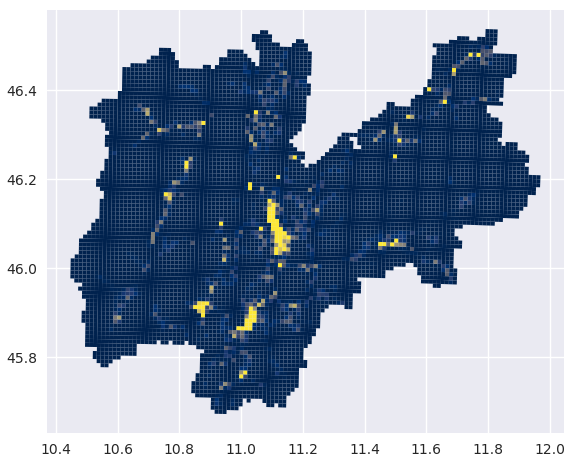

In [3]:
with plt.style.context('seaborn'):    
    grid.plot('consumi',vmin=0, vmax=200000,cmap='cividis')
plt.show()


### differenza dell'andamento dei consumi in base alla categoria di appartenenza
plotterò in tre grafici l'andamento dei consumi:
- nell'arco delle 24 ore
- nell'arco della settimana
- nell'arco dei due mesi

per ogni categoria di cella, mi aspetto 3 andamenti principali
quello delle celle di tipo industiale con picchi nei periodi lavorativi e nelle prime ore del giorno
quello dei piccoli centri abitati, più attivi durante le feste e la sera
quello dei grandi centri abitati, equamente attivo 

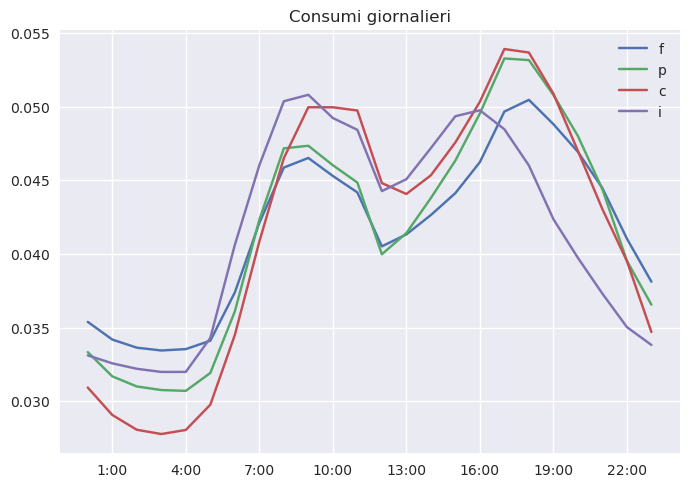

In [4]:
# dataframe con consumi e popolazione totale per ogni categoria
totali=grid.groupby(['category']).sum().drop(columns=['cellId'])
# attacco al DF dei consumi la colonna category
consumi2=consumi.merge(grid.loc[:,['cellId','category']], how='left', on='cellId')

# plot 1 dei ciclo giornaliero
eda.consumi_giornalieri(consumi2,totali)



### commenti
bene o male tutte le categorie scelte si comportano allo stesso modo nell'arco della giornata con picchi dei consumi in piena mattina e tardo pomeriggio. una piccola eccezione è data dalla categoria 'i' delle celle industriali in cui il picco più alto è la mattina e non il pomeriggio, inoltre il pomeriggio il picco è spostato rispetto a quelle delle altre categorie.
Il tutto è facilmente giustificabile considerando quelli che sono i tipici orari lavorativi 

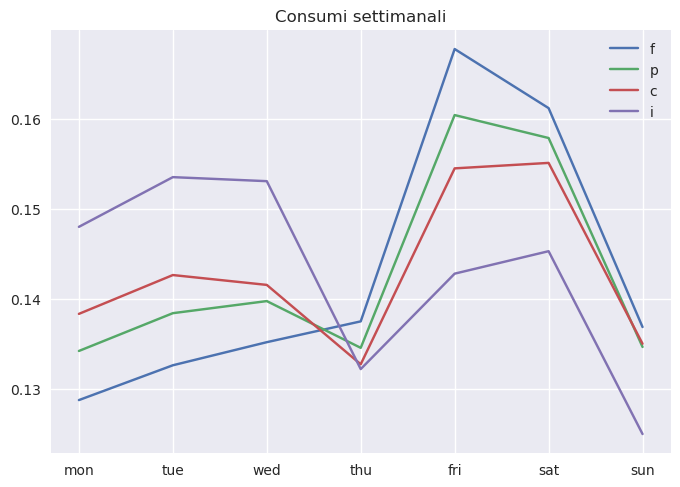

In [5]:
# plot 2 dei ciclo settimanale    
eda.consumi_settimanali(consumi2,totali)


### commenti
in questo grafico la differenza tra le varie categorie si fa ancora più marcata:
vediamo che più piccola è la località e più bassi sono i consumi infrasettimanali rispetto a quelli del weekend, fino ad avere il trend oppost per le aree industriali.
giustifichiamo questi andamenti reagionando che più piccolo è il paese e meno attività lavorative offre, per cui durante la settimana i suoi abitanti si rimangono gran parte della giornata in centri urbani di maggiori dimensioni, mentre nel weekend quando scuole e aziende sono chiusi rimancono a casa, per questo abbiamo qui il picco dei consumi.
Per le aree industriali invece l'andamento è giustamente l'opposto.


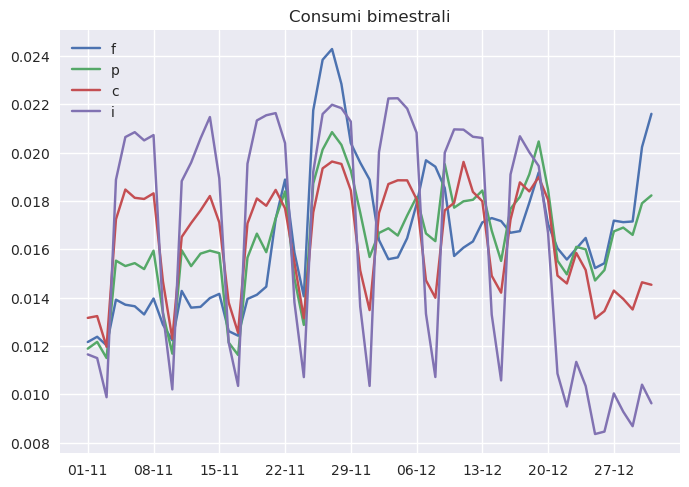

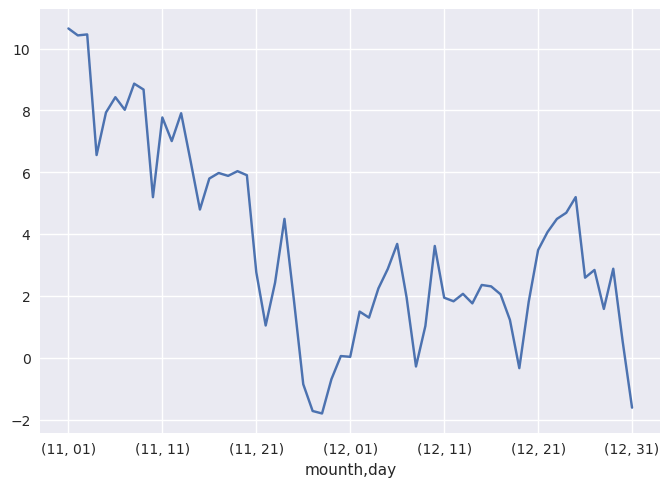

In [6]:


# plot 3 dei ciclo bimestrale
eda.consumi_bimestrali(consumi2,totali)

with plt.style.context('seaborn'):
    weather.groupby(['mounth','day']).mean().loc[:,'temper'].plot()
plt.show()

### commenti
nel grafico si vede chiaramente l'andamento settimanale abbastanza regolare con i minimi la domenica, perturbato alla fine dalla presenza delle feste di fine anno, in cui i consumi delle zone industriali droppano pesantemente con la chiusura delle fabbriche, mentre il consumo delle piccole frazioni vedode un importante crescita, complice la presenza di località montane in questa categoria con case vacanze e impianti sciistici ecc.

Si vede un progressivo incremento dei consumi con l'avanzare della stagione probabilmente dovuto all'abbassamento delle temperature (ben rappresentato dal grafico vede l'andamento nei due mesi della temperatura media su tutta la provincia), il che giustificherebbe perchè la categoria 'i' è meno affetta da questo trend dato che il consumo delle zone industriali non è tanto legato al riscaldamento degli ambienti quanto al funzionamento dei macchinari. Vediamo in un altro grafico tale correlazione

vediamo in un istogramma quale categoria ha il maggior consumi, normalizzo i consumi sul numero di celle che tali categorie occupano


In [7]:
consumixcella=grid.loc[:,['category','consumi']].groupby(['category']).count()
consumixcella['consumi']=totali['consumi']/consumixcella['consumi']
consumixcella=consumixcella.reindex(['b','a','f','sp','p','bp','c','bc','i'])

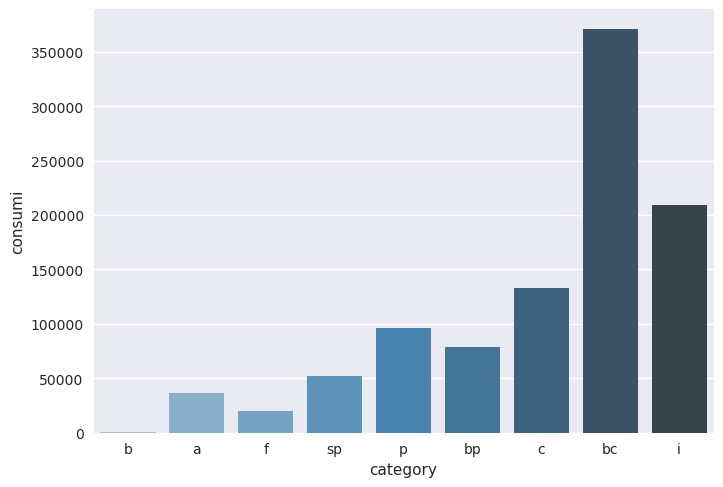

In [8]:
with plt.style.context('seaborn'):
    sns.barplot(x=consumixcella.index,y='consumi' ,data=consumixcella,palette="Blues_d")
plt.show()

niente di che da commentare, mi stupisce blandamentre il fatto che i gradi paesi (bp) abbiano consumi relativi minori dei paesi di medie dimensioni (p) ma nulla di troppo serio, certamente legato a come sono state classificate le celle in maniere abbastanza approssimativa per queste classi intermedie

### relazione dei consumi con la temperatura
Non è molto facile cercare di visualizzare in un grafico tale relazione:
ho pensato di sommare tutti i consumi ad una certa temperatura e dividerli per il numero di rilevazioni cosi da avere una sorta di normalizzazione. non è comunque molto rappresentativo poichè piccoli centri montani rileveranno basse temperature che nei maggiori centri urbani non verranno mai registrate, ma date le dimensioni dei piccoli centri a queste basse temperature verranno per forza assegnati bassi consumi

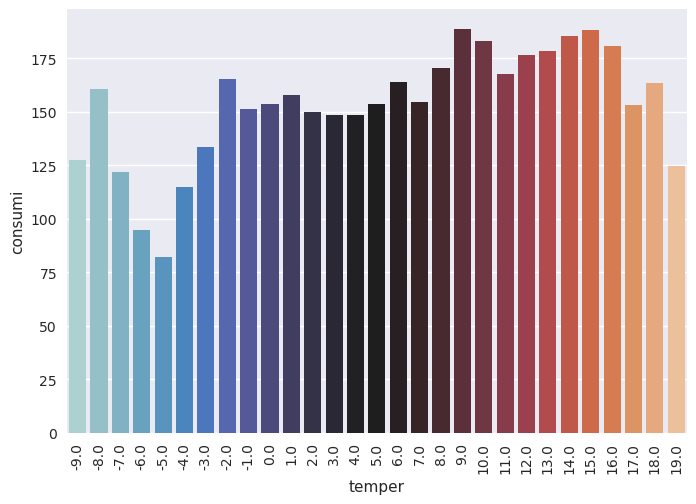

In [9]:
#inserire in input la categoria di località da vedere oppure 'tot' per il totale
eda.consumi_temp('bp')

per le località di piccole dimensioni 'f' 'sp' 'p' si registra una tendenza ad aumentare i consumi con il diminuire delle temperature, per le altre località invece i consumi sembrerebbero abbastanza indipendenti dalle temperature,
questo semprerebbe avere abbastanza senso considerando che le località di più piccola dimensione sono per lo più residenziali per cui i consumi derivano dalla gestione della casa e del suo riscaldamento **stiamo comunque considerando consumi elettrici e in generale il riscaldamento è legato al gas quindi anche per questo l'impatto della temperatura è meno visibile**

### relazione dei consumi con le precipitazioni
faccio un discorso simile a quello delle temperature, solo che al posto delle temperature uso l'intensità delle piogge

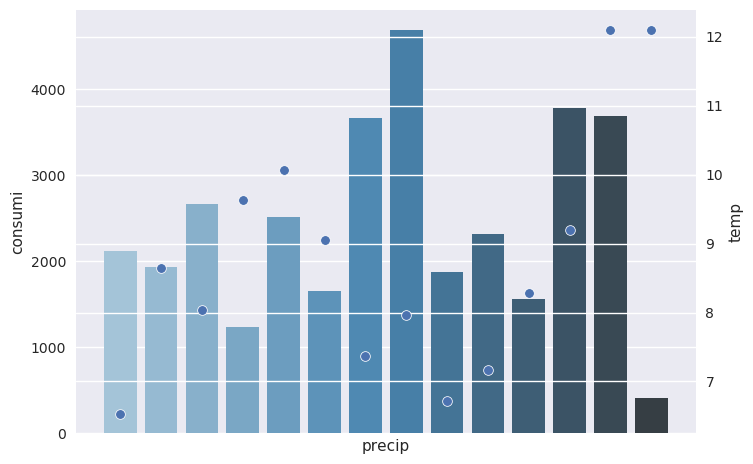

In [10]:
#inserire in input la categoria di località da vedere oppure 'tot' per il totale
eda.consumi_precip('c')


### relazione tra consumi e inquinanti (città di Trento)
plotto per ogni giorno il valore di alcuni dei 6 inquinanti in relazione ai consumi totali della città
alcuni come PM10 e PM2.5 oppure i ossido e biossidi hanno un andamento simile quindi tengo solo uno per gruppo

dato che il plot viene abbastanza confuso guardo anche la amtrice ci correlazioni di perason


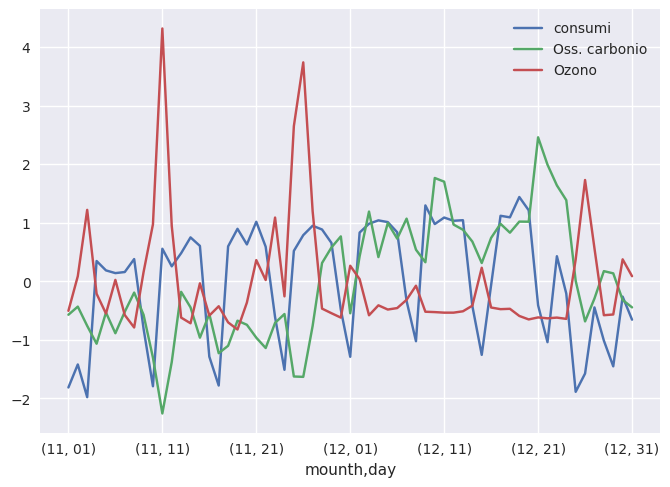

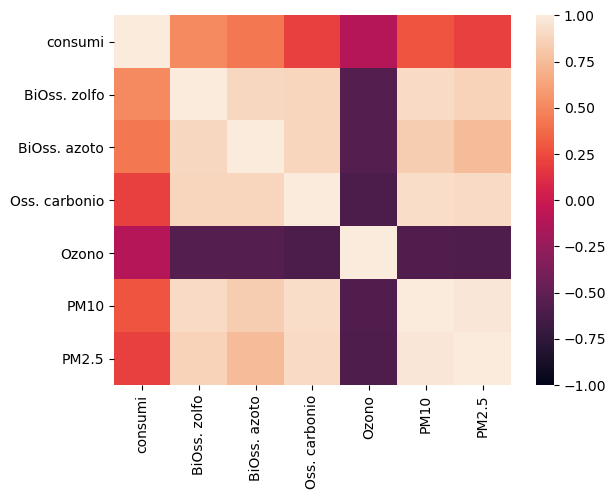

In [11]:
# lo faccio solo per avere la data come indice, forse ci sono altri modi chi lo sa
APPA=appa.groupby(['mounth','day']).sum()
# per un buon confronto mi conviene riscalare tutto
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

APPA = pd.DataFrame(scaler.fit_transform(APPA), columns=APPA.columns, index=APPA.index)

with plt.style.context('seaborn'):
    APPA.drop(columns=['PM10','BiOss. azoto','BiOss. zolfo','PM2.5']).plot()
    #sns.barplot( y='consumi' ,data=APPA,palette="Blues_d")
plt.show()


matrix_appa=APPA.corr(method='pearson')
sns.heatmap(matrix_appa, vmax=1, vmin=-1)
plt.show() 

sia dal grafico che dalla matrice di correlazione si vede un leggero legame tra i consumi egli agenti inquinanti ed ozono.
infatti a minimi dei consumi corrispondono picchi nelle percentuali di ozono(spostati di un paio di giorni) e minimi degli altri agenti inquinanti, anche se non molto evidenti regolari. 
se bisogna essere scettici però non mi azzarderei a dire che ci sia un effettivo rapporto di causa effetto anche perchè la correlazione probabilmente è dovuta al fatto che nel corso della settimana si manifestino altri fattori che possono andar a contribuire alla presenza di inquinanti nell'aria come il traffico che nel weekend è meno accentuato che negli altri giorni
**correlation doesn't imply causation**

### correlazione di pearson
costruisco un dataframe contenente per ogni cella attiva:
- il consumo totale
- la temperatura media
- le precipitazioni totali
- rapporto dei consumi festivi rispetto a quelli totali (sabato, domenica e feste comandate)
- rapporto dei consumi dell'orario di lavor rispetto a quelli totali (dalle 7.00 alle 19.00)
- categoria di appartamento (one hot encoding)

In [12]:
# creiamo il dataframe pearson a partire da quello dei consumi
pearson=consumi.drop(columns=['year','utenze'])

# aggiungo la colonna che mi indica se è orario lavorativo, (giorno)
pearson=pearson.astype({"hour": int})
pearson['giorno']=np.select([(pearson['hour']>=7) & (pearson['hour']<19)], [True])

# aggiungo la colonna che mi indica se il giorno è festivo
conditions = [
    (pearson['week'] == 'sun'),
    (pearson['mounth'] == '11') & (pearson['day'] == '01'),
    (pearson['mounth'] == '12') & ((pearson['day'] == '25') | (pearson['day'] == '26'))
    ]
values = [True,True,True]
pearson['festivo'] = np.select(conditions, values)

#pearson.drop(columns=['','utenze'])
giorno=pearson.groupby(['cellId','giorno']).sum()
giorno.reset_index(level=[1],inplace=True)

festivo=pearson.groupby(['cellId','festivo']).sum()
festivo.reset_index(level=[1],inplace=True)

pearson=pearson.loc[:,['cellId','consumi']].groupby(['cellId']).sum()

pearson['giorno']=giorno[giorno['giorno']==1]['consumi']/pearson['consumi']
pearson['festivo']=festivo[festivo['festivo']==1]['consumi']/pearson['consumi']


# aggiungo la temperatura e le precipitazioni
df_w=eda.dataframe_weather()
pearson['temp']=df_w.groupby(['cellId']).mean()['temper']
pearson['precip']=df_w.groupby(['cellId']).sum()['precip']

# aggiungo le classi in OneHot
pearson=pearson.merge(grid.loc[:,['cellId','category']], how='left', on=['cellId'])
pearson=pd.concat([pearson, pd.get_dummies(pearson['category'])], axis=1)

pearson.drop(columns=['category','cellId'], inplace=True)

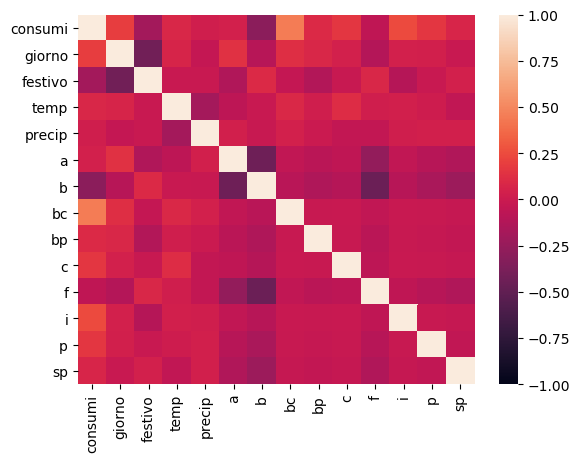

In [13]:

#riscalo
pearson_scal = pd.DataFrame(scaler.fit_transform(pearson), columns=pearson.columns, index=pearson.index)


corr_matrix=pearson_scal.corr(method='pearson')
sns.heatmap(corr_matrix,vmax=1, vmin=-1)
plt.show() 

In [14]:
eda.top_correlation(corr_matrix,10)

consumi : bc 	= 0.45058484933073184
giorno : festivo 	= -0.41685229176715705
consumi : b 	= -0.3000156345320002
consumi : i 	= 0.24341890489340948
consumi : festivo 	= -0.19075642525632813
consumi : giorno 	= 0.18842214146980912
temp : precip 	= -0.18384912615285381
consumi : c 	= 0.1575555245897961
consumi : p 	= 0.15677150132649886
giorno : a 	= 0.13859172003000111
